In [5]:
import pandas as pd
import os

# Establecer la carpeta de trabajo
#os.chdir("/Users/bautistagoulu/Desktop/Big Data")
os.chdir("/Users/francodeangelis/Documents/Udesa/cuarto /Big data /BigDataUdeSA/GitHub/E337-Grupo8/Big_Data_TP3_Grupo8")
#os.chdir("C:/Udesa/Big Data/TP3")
# Cargar la base de datos
df = pd.read_excel("respondieron2.xlsx")




In [6]:

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# ------------------------------
# Supongamos que ya tenemos df cargado y limpio
# ------------------------------

# Crear dummy mujer si no existe
df["dummy_mujer"] = (df["CH04"] == 2).astype(int)

# Filtrar año 2024
df_2024 = df[df["ANO4"] == 2024].copy()

# Variables seleccionadas (como en TP3)
variables_X = ["dummy_casado", "dummy_secundario_completo", "dummy_superior_completo", "dummy_mujer"]
X = df_2024[variables_X]
y = df_2024["dummy_desocupado"].astype(int)

# Train-test split (70-30, semilla 444)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=444)

# ------------------------------
# Cross-validation para Ridge y LASSO
# ------------------------------

from sklearn.linear_model import LogisticRegressionCV

# Grilla de lambdas
lambdas_ridge = np.logspace(-5, 5, 50)
lambdas_lasso = np.logspace(-4, 4, 20)

# RIDGE (penalización L2)
ridge_model = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('ridge_cv', LogisticRegressionCV(
        Cs=1/lambdas_ridge,
        cv=10,
        penalty='l2',
        solver='liblinear',
        scoring='accuracy',
        max_iter=1000,
        random_state=42
    ))
])
ridge_model.fit(X_train, y_train)
best_lambda_ridge = 1 / ridge_model.named_steps['ridge_cv'].C_[0]

# LASSO (penalización L1)
lasso_model = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('lasso_cv', LogisticRegressionCV(
        Cs=1/lambdas_lasso,
        cv=10,
        penalty='l1',
        solver='liblinear',
        scoring='accuracy',
        max_iter=1000,
        random_state=42
    ))
])
lasso_model.fit(X_train, y_train)
best_lambda_lasso = 1 / lasso_model.named_steps['lasso_cv'].C_[0]

print(f"Mejor λ para Ridge: {best_lambda_ridge:.6f}")
print(f"Mejor λ para LASSO: {best_lambda_lasso:.6f}")


Mejor λ para Ridge: 0.000010
Mejor λ para LASSO: 0.000100


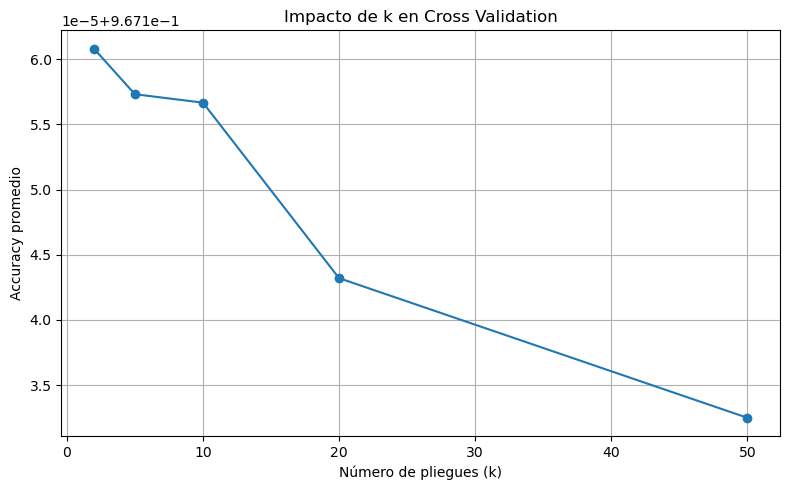

k = 2: Accuracy promedio = 0.9672
k = 5: Accuracy promedio = 0.9672
k = 10: Accuracy promedio = 0.9672
k = 20: Accuracy promedio = 0.9671
k = 50: Accuracy promedio = 0.9671


In [15]:
#2
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold
import numpy as np
import matplotlib.pyplot as plt

# Modelo sin penalización (penalty=None en lugar de 'none')
modelo = LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000)

# Valores de k a probar
valores_k = [2, 5, 10, 20, 50]
scores_promedio = []

# Evaluamos para cada k
for k in valores_k:
    cv = KFold(n_splits=k, shuffle=True, random_state=42)
    scores = cross_val_score(modelo, X_train, y_train, cv=cv, scoring='accuracy')
    scores_promedio.append(scores.mean())

# Gráfico de resultados
plt.figure(figsize=(8, 5))
plt.plot(valores_k, scores_promedio, marker='o')
plt.xlabel('Número de pliegues (k)')
plt.ylabel('Accuracy promedio')
plt.title('Impacto de k en Cross Validation')
plt.grid(True)
plt.tight_layout()
plt.show()

# Imprimir tabla
for k, acc in zip(valores_k, scores_promedio):
    print(f"k = {k}: Accuracy promedio = {acc:.4f}")





In [25]:
#3
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, roc_curve
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

# Función para preparar los datos de cada año
def preparar_datos_por_año(df, año):
    df_anual = df[df["ANO4"] == año].copy()
    df_anual["dummy_mujer"] = (df_anual["CH04"] == 2).astype(int)
    variables = ["dummy_casado", "dummy_secundario_completo", "dummy_superior_completo", "dummy_mujer"]
    X = df_anual[variables]
    y = df_anual["dummy_desocupado"].astype(int)
    return train_test_split(X, y, test_size=0.3, random_state=444)

# Inicializamos el diccionario de resultados
resultados_modelos = {}

# Grillas de lambda (C = 1/lambda)
lambdas_ridge = np.logspace(-5, 5, 50)
lambdas_lasso = np.logspace(-4, 4, 20)

# Evaluamos para los años 2004 y 2024
for año in [2004, 2024]:
    X_train, X_test, y_train, y_test = preparar_datos_por_año(df, año)

    # Modelo Ridge (penalización L2)
    ridge_model = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('ridge_cv', LogisticRegressionCV(
            Cs=1/lambdas_ridge,
            cv=10,
            penalty='l2',
            solver='liblinear',
            scoring='accuracy',
            max_iter=1000,
            random_state=42
        ))
    ])
    ridge_model.fit(X_train, y_train)
    y_prob_ridge = ridge_model.predict_proba(X_test)[:, 1]
    y_pred_ridge = ridge_model.predict(X_test)

    # Evaluación Ridge
    conf_ridge = confusion_matrix(y_test, y_pred_ridge)
    auc_ridge = roc_auc_score(y_test, y_prob_ridge)
    acc_ridge = accuracy_score(y_test, y_pred_ridge)
    fpr_ridge, tpr_ridge, _ = roc_curve(y_test, y_prob_ridge)

    # Modelo LASSO (penalización L1)
    lasso_model = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('lasso_cv', LogisticRegressionCV(
            Cs=1/lambdas_lasso,
            cv=10,
            penalty='l1',
            solver='liblinear',
            scoring='accuracy',
            max_iter=1000,
            random_state=42
        ))
    ])
    lasso_model.fit(X_train, y_train)
    y_prob_lasso = lasso_model.predict_proba(X_test)[:, 1]
    y_pred_lasso = lasso_model.predict(X_test)

    # Evaluación LASSO
    conf_lasso = confusion_matrix(y_test, y_pred_lasso)
    auc_lasso = roc_auc_score(y_test, y_prob_lasso)
    acc_lasso = accuracy_score(y_test, y_pred_lasso)
    fpr_lasso, tpr_lasso, _ = roc_curve(y_test, y_prob_lasso)

    # Guardamos resultados en diccionario
    resultados_modelos[año] = {
        "Ridge": {
            "confusion": conf_ridge,
            "auc": auc_ridge,
            "acc": acc_ridge,
            "fpr": fpr_ridge,
            "tpr": tpr_ridge
        },
        "LASSO": {
            "confusion": conf_lasso,
            "auc": auc_lasso,
            "acc": acc_lasso,
            "fpr": fpr_lasso,
            "tpr": tpr_lasso
        }
    }

# Mostrar resumen de resultados
resumen = []
for año in resultados_modelos:
    for metodo in ["Ridge", "LASSO"]:
        res = resultados_modelos[año][metodo]
        resumen.append({
            "Año": año,
            "Método": metodo,
            "Accuracy": round(res["acc"], 4),
            "AUC": round(res["auc"], 4),
            "Matriz de Confusión": res["confusion"]
        })

df_resumen = pd.DataFrame(resumen)
print(df_resumen)



    Año Método  Accuracy     AUC   Matriz de Confusión
0  2004  Ridge    0.9244  0.4176   [[208, 0], [17, 0]]
1  2004  LASSO    0.9244  0.4176   [[208, 0], [17, 0]]
2  2024  Ridge    0.9670  0.5918  [[1200, 0], [41, 0]]
3  2024  LASSO    0.9670  0.5918  [[1200, 0], [41, 0]]


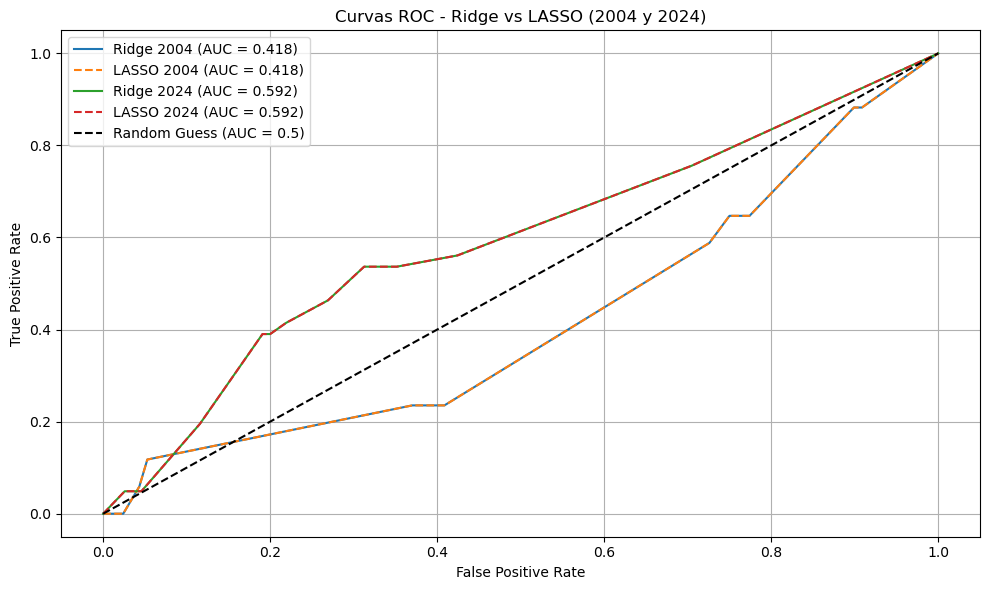

In [27]:
import matplotlib.pyplot as plt

# Graficamos curvas ROC para ambos años y métodos
plt.figure(figsize=(10, 6))

for año in [2004, 2024]:
    for metodo, estilo in zip(["Ridge", "LASSO"], ["-", "--"]):
        fpr = resultados_modelos[año][metodo]["fpr"]
        tpr = resultados_modelos[año][metodo]["tpr"]
        auc = resultados_modelos[año][metodo]["auc"]
        plt.plot(fpr, tpr, linestyle=estilo, label=f"{metodo} {año} (AUC = {auc:.3f})")

# Línea base (predicción aleatoria)
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess (AUC = 0.5)")

# Etiquetas y formato
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curvas ROC - Ridge vs LASSO (2004 y 2024)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


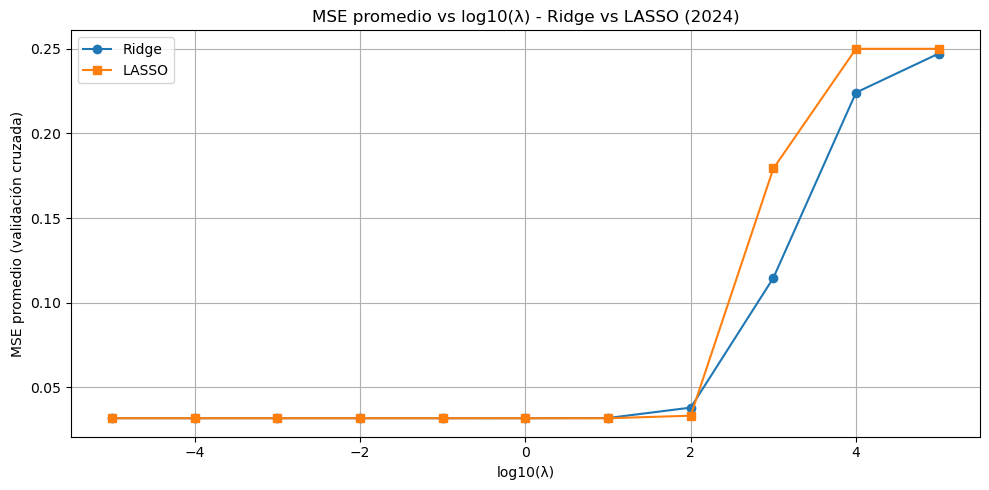

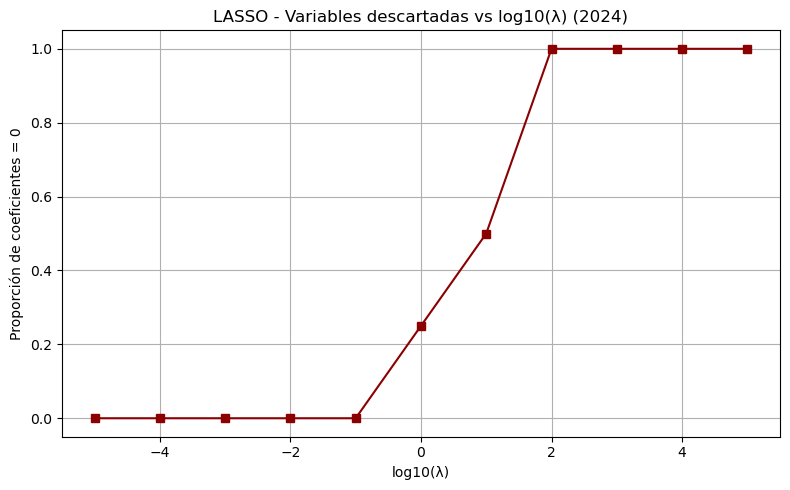

λ óptimo para Ridge: 1.0
λ óptimo para LASSO: 10.0


In [35]:
#4
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_predict, KFold
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# --- Cargar y preparar datos ---
df = pd.read_excel("respondieron2.xlsx")  # Asegurate de que este archivo esté en tu directorio
df["dummy_mujer"] = (df["CH04"] == 2).astype(int)

variables = ["dummy_casado", "dummy_secundario_completo", "dummy_superior_completo", "dummy_mujer"]
df_2024 = df[df["ANO4"] == 2024].copy()

X = df_2024[variables]
y = df_2024["dummy_desocupado"].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=444)

# --- Definir grilla de λ ---
n_vals = np.arange(-5, 6)
lambdas = 10.0 ** n_vals  # <- CORREGIDO: usar 10.0 para evitar error de enteros
Cs = 1 / lambdas

# --- Inicializar listas para resultados ---
mse_ridge = []
mse_lasso = []
proporcion_descartadas_lasso = []

cv = KFold(n_splits=10, shuffle=True, random_state=42)

# --- Barrido de λ ---
for C in Cs:
    # Ridge
    ridge = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('logreg', LogisticRegression(penalty='l2', C=C, solver='liblinear', max_iter=1000))
    ])
    y_pred_ridge = cross_val_predict(ridge, X_train, y_train, cv=cv, method='predict_proba')[:, 1]
    mse_ridge.append(mean_squared_error(y_train, y_pred_ridge))

    # LASSO
    lasso = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('logreg', LogisticRegression(penalty='l1', C=C, solver='liblinear', max_iter=1000))
    ])
    y_pred_lasso = cross_val_predict(lasso, X_train, y_train, cv=cv, method='predict_proba')[:, 1]
    mse_lasso.append(mean_squared_error(y_train, y_pred_lasso))

    # Proporción de coeficientes descartados (0) por LASSO
    lasso.fit(X_train, y_train)
    coef = lasso.named_steps['logreg'].coef_[0]
    proporción_ceros = np.mean(coef == 0)
    proporcion_descartadas_lasso.append(proporción_ceros)

# --- Gráfico MSE promedio ---
plt.figure(figsize=(10, 5))
plt.plot(n_vals, mse_ridge, marker='o', label='Ridge')
plt.plot(n_vals, mse_lasso, marker='s', label='LASSO')
plt.xlabel("log10(λ)")
plt.ylabel("MSE promedio (validación cruzada)")
plt.title("MSE promedio vs log10(λ) - Ridge vs LASSO (2024)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Gráfico proporción de variables descartadas (LASSO) ---
plt.figure(figsize=(8, 5))
plt.plot(n_vals, proporcion_descartadas_lasso, marker='s', color='darkred')
plt.xlabel("log10(λ)")
plt.ylabel("Proporción de coeficientes = 0")
plt.title("LASSO - Variables descartadas vs log10(λ) (2024)")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Imprimir los mejores λ ---
mejor_lambda_ridge = lambdas[np.argmin(mse_ridge)]
mejor_lambda_lasso = lambdas[np.argmin(mse_lasso)]

print("λ óptimo para Ridge:", mejor_lambda_ridge)
print("λ óptimo para LASSO:", mejor_lambda_lasso)







In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Usar el mejor λ hallado anteriormente
C_optimo_lasso = 1 / mejor_lambda_lasso  # recordá que en sklearn: C = 1/λ

# Modelo LASSO con ese λ
modelo_lasso_final = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(
        penalty='l1',
        C=C_optimo_lasso,
        solver='liblinear',
        max_iter=1000
    ))
])

# Entrenamos sobre todo el conjunto de entrenamiento
modelo_lasso_final.fit(X_train, y_train)

# Obtenemos los coeficientes
coeficientes = modelo_lasso_final.named_steps['logreg'].coef_[0]

# Asociamos coeficientes con nombres de variables
variables = X_train.columns
descartadas = [var for var, c in zip(variables, coeficientes) if c == 0]
seleccionadas = [var for var, c in zip(variables, coeficientes) if c != 0]

# Mostramos resultados
print("🔴 Variables descartadas por LASSO (coeficiente = 0):")
for v in descartadas:
    print("-", v)

print("\n🟢 Variables seleccionadas por LASSO (coeficiente ≠ 0):")
for v in seleccionadas:
    print("-", v)


🔴 Variables descartadas por LASSO (coeficiente = 0):
- dummy_superior_completo
- dummy_mujer

🟢 Variables seleccionadas por LASSO (coeficiente ≠ 0):
- dummy_casado
- dummy_secundario_completo


In [39]:
#5
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Modelo sin regularización
modelo_sin_penal = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000))
])
modelo_sin_penal.fit(X_train, y_train)
y_pred_sin = modelo_sin_penal.predict(X_test)
acc_sin = accuracy_score(y_test, y_pred_sin)
coef_sin = modelo_sin_penal.named_steps['logreg'].coef_[0]

# Modelo Ridge
modelo_ridge = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(penalty='l2', C=1.0, solver='liblinear', max_iter=1000))
])
modelo_ridge.fit(X_train, y_train)
y_pred_ridge = modelo_ridge.predict(X_test)
acc_ridge = accuracy_score(y_test, y_pred_ridge)
coef_ridge = modelo_ridge.named_steps['logreg'].coef_[0]

# Modelo LASSO
modelo_lasso = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(penalty='l1', C=1.0, solver='liblinear', max_iter=1000))
])
modelo_lasso.fit(X_train, y_train)
y_pred_lasso = modelo_lasso.predict(X_test)
acc_lasso = accuracy_score(y_test, y_pred_lasso)
coef_lasso = modelo_lasso.named_steps['logreg'].coef_[0]

# Mostrar resultados
for nombre, acc, coef in zip(
    ["Sin penalización", "Ridge", "LASSO"],
    [acc_sin, acc_ridge, acc_lasso],
    [coef_sin, coef_ridge, coef_lasso]
):
    print(f"\n🔎 {nombre}")
    print(f"Accuracy: {acc:.4f}")
    for var, c in zip(X_train.columns, coef):
        print(f"{var}: {c:.4f}")



🔎 Sin penalización
Accuracy: 0.9670
dummy_casado: 0.1614
dummy_secundario_completo: 0.2839
dummy_superior_completo: 0.0712
dummy_mujer: -0.0060

🔎 Ridge
Accuracy: 0.9670
dummy_casado: 0.1558
dummy_secundario_completo: 0.2735
dummy_superior_completo: 0.0672
dummy_mujer: -0.0056

🔎 LASSO
Accuracy: 0.9670
dummy_casado: 0.1534
dummy_secundario_completo: 0.2711
dummy_superior_completo: 0.0557
dummy_mujer: 0.0000


In [49]:
#6
from sklearn.metrics import roc_auc_score, accuracy_score

# Función auxiliar para entrenar, predecir y evaluar
def evaluar_modelo(modelo, nombre):
    modelo.fit(X_train, y_train)
    y_pred_train = modelo.predict(X_train)
    y_pred_test = modelo.predict(X_test)

    y_prob_train = modelo.predict_proba(X_train)[:, 1]
    y_prob_test = modelo.predict_proba(X_test)[:, 1]

    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred_test)
    auc_train = roc_auc_score(y_train, y_prob_train)
    auc_test = roc_auc_score(y_test, y_prob_test)

    print(f"\n🔎 {nombre}")
    print(f"Accuracy train: {acc_train:.4f} | test: {acc_test:.4f}")
    print(f"AUC train: {auc_train:.4f} | test: {auc_test:.4f}")

# Modelo sin penalización
modelo_sin = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000))
])

# Modelo Ridge
modelo_ridge = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(penalty='l2', C=1.0, solver='liblinear', max_iter=1000))
])

# Modelo LASSO
modelo_lasso = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(penalty='l1', C=1.0, solver='liblinear', max_iter=1000))
])

# Evaluar todos
evaluar_modelo(modelo_sin, "Regresión logística sin penalización")
evaluar_modelo(modelo_ridge, "Ridge (L2)")
evaluar_modelo(modelo_lasso, "LASSO (L1)")



🔎 Regresión logística sin penalización
Accuracy train: 0.9672 | test: 0.9670
AUC train: 0.6260 | test: 0.5918

🔎 Ridge (L2)
Accuracy train: 0.9672 | test: 0.9670
AUC train: 0.6260 | test: 0.5918

🔎 LASSO (L1)
Accuracy train: 0.9672 | test: 0.9670
AUC train: 0.6161 | test: 0.5995


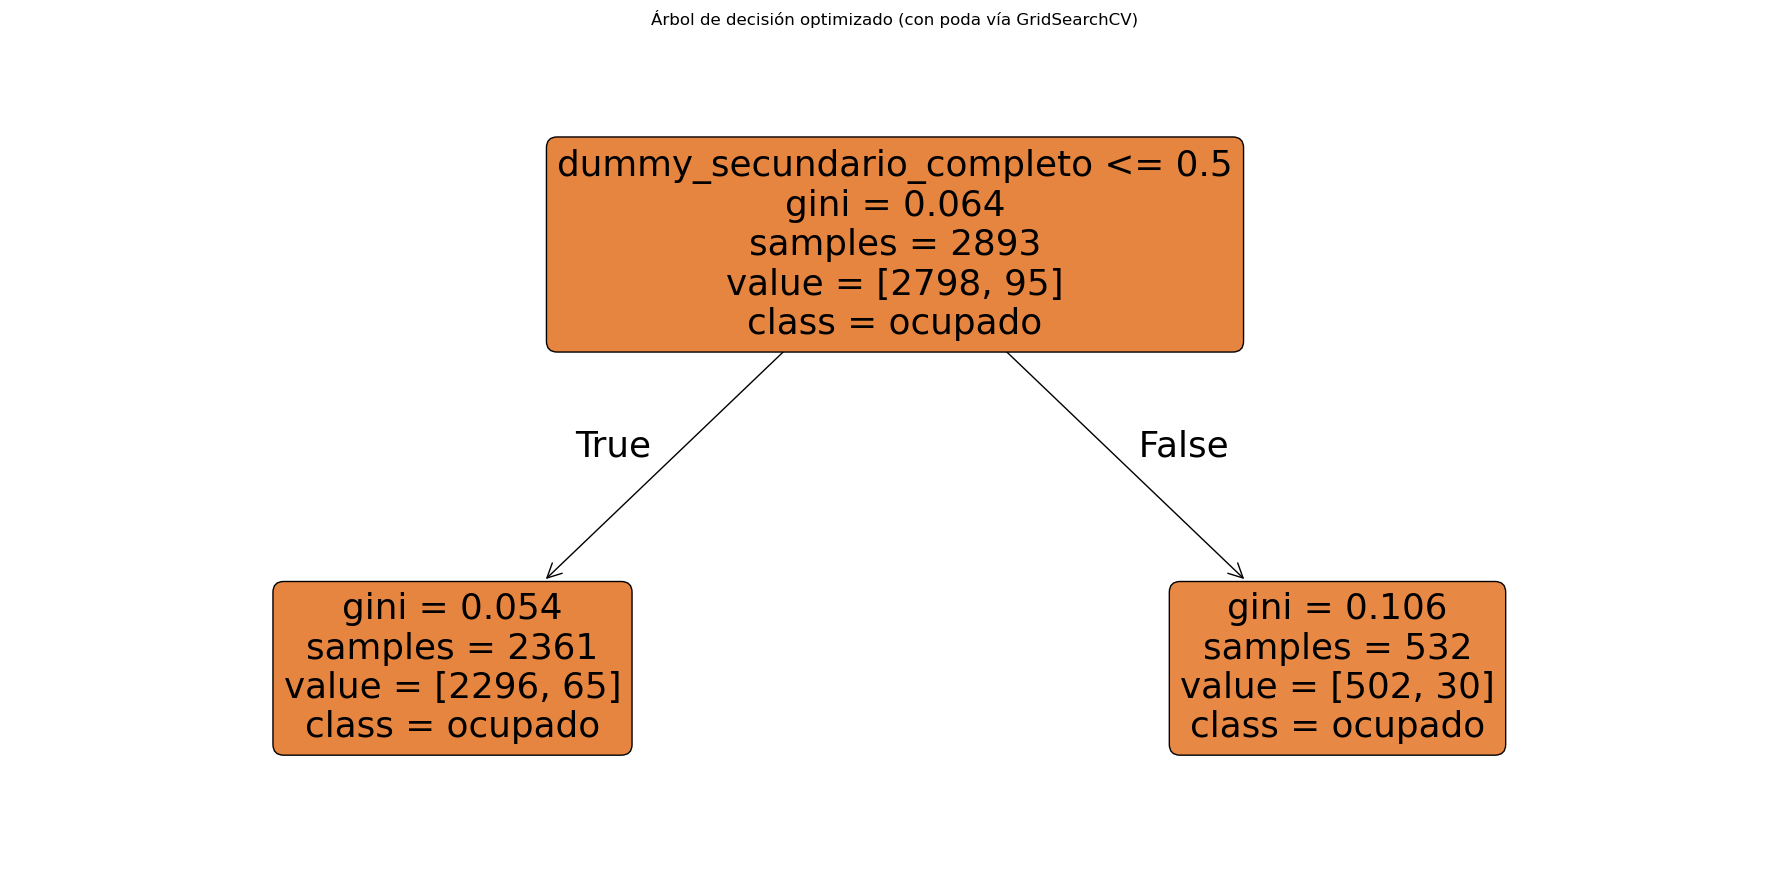

In [65]:
#7
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import pandas as pd
import matplotlib.pyplot as plt

# Cargar datos
df = pd.read_excel("respondieron2.xlsx")  # Ajustá ruta si hace falta
df["dummy_mujer"] = (df["CH04"] == 2).astype(int)
df_2024 = df[df["ANO4"] == 2024].copy()

variables = ["dummy_casado", "dummy_secundario_completo", "dummy_superior_completo", "dummy_mujer"]
X = df_2024[variables]
y = df_2024["dummy_desocupado"].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=444)

# Búsqueda de mejor árbol (poda)
param_grid = {
    "max_depth": list(range(1, 11)),
    "min_samples_split": [2, 5, 10]
}
grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)
grid_search.fit(X_train, y_train)
mejor_arbol = grid_search.best_estimator_

# Graficar árbol final podado
plt.figure(figsize=(18, 9))
plot_tree(
    mejor_arbol,
    feature_names=X_train.columns,
    class_names=["ocupado", "desocupado"],
    filled=True,
    rounded=True
)
plt.title("Árbol de decisión optimizado (con poda vía GridSearchCV)")
plt.tight_layout()
plt.show()
